# Regresión supervisada 

El objetivo de este notebook es explorar y modelar mediante regresión supervisada (Regresión lineal y polinómica) la relación entre un hiperparámetro del solver y su desempeño.

$$
T_0​⟶E[\text{best cut}]
$$

> Nota importante: Para más información del contexto del problema consultar las notas del proyecto `notes.md`

## Estructura del código
```mermaid
    graph LR
    A[1 <br> Carga de dataset]
    B[2 <br> Preprocesamiento y visualización rápida]
    C[3 <br> Agregación por T0 y visualización]
    D[4 <br> Preparación de datos para regresión - train/test split]
    E[5 <br> Modelos de regresión y evaluación]
    F[6 <br> Visualización de las curvas aprendidas]

    A --> B
    B --> C
    C --> D
    D --> E
    E --> F

    style A fill: #6477bd 
    style B fill: #6477bd 
    style C fill: #6477bd 
    style D fill: #6477bd 
    style E fill: #6477bd 
    style F fill: #6477bd 
```

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score


In [ ]:
# 1. Carga de dataset
df_reg = pd.read_csv("C:/Users/nat27/Desktop/Desktop/Proyectos/Physics/MaxCut-Ising-Annealing/data/sa_maxcut_runs_dataset.csv")
df_reg.head()

,run_id,T0,logT0,seed,best_cut,final_cut,best_energy,final_energy
0,0,0.5,-0.693147,100,52.0,52.0,-52.0,-52.0
1,1,0.5,-0.693147,101,51.0,51.0,-51.0,-51.0
2,2,0.5,-0.693147,102,52.0,52.0,-52.0,-52.0
3,3,0.5,-0.693147,103,52.0,52.0,-52.0,-52.0
4,4,0.5,-0.693147,104,52.0,52.0,-52.0,-52.0


In [ ]:
# 2. Preprocesamiento y visualización rápida
required_cols = {"T0", "best_cut", "final_cut", "best_energy", "final_energy"}
missing = required_cols - set(df_reg.columns)
if missing:
    raise ValueError(f"Faltan columnas requeridas: {missing}")

In [ ]:
df_reg = df_reg.replace([np.inf, -np.inf], np.nan).dropna(subset=["T0", "logT0", "best_cut", "final_cut"])
df_reg.describe(include="all")

,run_id,T0,logT0,seed,best_cut,final_cut,best_energy,final_energy
count,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000,180.000000
mean,89.500000,3.411111,0.778371,189.500000,51.538889,50.944444,-51.538889,-50.944444
std,52.105662,3.104671,0.985112,52.105662,1.032239,1.127226,1.032239,1.127226
min,0.000000,0.500000,-0.693147,100.000000,47.000000,47.000000,-52.000000,-52.000000
25%,44.750000,1.000000,0.000000,144.750000,52.000000,50.000000,-52.000000,-52.000000
50%,89.500000,2.000000,0.693147,189.500000,52.000000,51.000000,-52.000000,-51.000000
75%,134.250000,5.000000,1.609438,234.250000,52.000000,52.000000,-52.000000,-50.000000
max,179.000000,10.000000,2.302585,279.000000,52.000000,52.000000,-47.000000,-47.000000


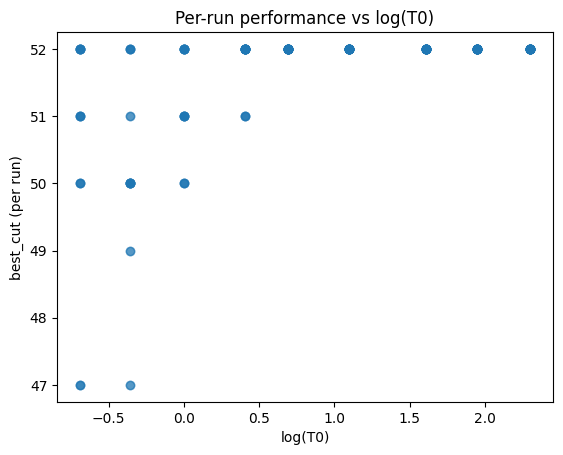

In [15]:
plt.figure()
plt.scatter(df_reg["logT0"], df_reg["best_cut"], alpha=0.5)
plt.xlabel("log(T0)")
plt.ylabel("best_cut (per run)")
plt.title("Per-run performance vs log(T0)")
plt.show()


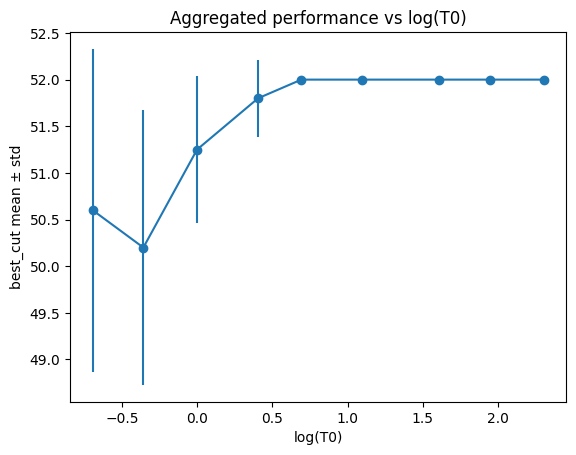

,T0,best_cut_mean,best_cut_std,final_cut_mean,final_cut_std,n,logT0
0,0.5,50.60,1.729009,50.60,1.729009,20,-0.693147
1,0.7,50.20,1.472556,50.20,1.472556,20,-0.356675
2,1.0,51.25,0.786398,51.25,0.786398,20,0.000000
3,1.5,51.80,0.410391,51.10,0.911910,20,0.405465
4,2.0,52.00,0.000000,51.10,1.020836,20,0.693147
5,3.0,52.00,0.000000,51.45,0.825578,20,1.098612
6,5.0,52.00,0.000000,51.05,0.887041,20,1.609438
7,7.0,52.00,0.000000,50.85,0.745160,20,1.945910
8,10.0,52.00,0.000000,50.90,1.071153,20,2.302585


In [ ]:
# 3. Agregación por T0 y visualización
agg = df_reg.groupby("T0").agg(
    best_cut_mean=("best_cut", "mean"),
    best_cut_std=("best_cut", "std"),
    final_cut_mean=("final_cut", "mean"),
    final_cut_std=("final_cut", "std"),
    n=("best_cut", "size")
).reset_index()

agg["logT0"] = np.log(agg["T0"])
agg.sort_values("T0", inplace=True)

plt.figure()
plt.errorbar(agg["logT0"], agg["best_cut_mean"], yerr=agg["best_cut_std"], fmt="o-")
plt.xlabel("log(T0)")
plt.ylabel("best_cut mean ± std")
plt.title("Aggregated performance vs log(T0)")
plt.show()

agg


In [ ]:
# 4. Preparación de datos para regresión (train/test split)
X = df_reg[["logT0"]].values
y_best = df_reg["best_cut"].values
y_final = df_reg["final_cut"].values

X_train, X_test, yb_train, yb_test = train_test_split(X, y_best, test_size=0.25, random_state=42)
_, _, yf_train, yf_test = train_test_split(X, y_final, test_size=0.25, random_state=42)

X_train.shape, X_test.shape


((135, 1), (45, 1))

In [ ]:
# 5. Modelos de regresión y evaluación

def eval_model(name, model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    return {
        "model": name,
        "MAE": mean_absolute_error(y_test, pred),
        "MSE": mean_squared_error(y_test, pred),
        "RMSE": mean_squared_error(y_test, pred) ** 0.5,
        "R2": r2_score(y_test, pred)
    }, pred

models = {
    "Linear": LinearRegression(),
    "Poly2": Pipeline([("poly", PolynomialFeatures(degree=2, include_bias=False)),
                       ("lr", LinearRegression())]),
    "Poly3_Ridge": Pipeline([("poly", PolynomialFeatures(degree=3, include_bias=False)),
                             ("ridge", Ridge(alpha=1.0))]),
}

# ---- Target: best_cut ----
results_best = []
preds_best = {}

for name, model in models.items():
    res, pred = eval_model(name, model, X_train, yb_train, X_test, yb_test)
    results_best.append(res)
    preds_best[name] = pred

pd.DataFrame(results_best).sort_values("RMSE")

,model,MAE,MSE,RMSE,R2
1,Poly2,0.416436,0.495598,0.703987,0.427831
2,Poly3_Ridge,0.442983,0.519246,0.720587,0.400529
0,Linear,0.526772,0.612168,0.782411,0.293250


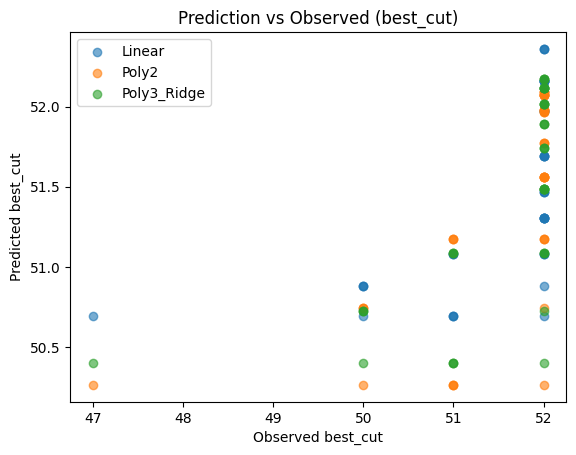

In [ ]:

plt.figure()
plt.scatter(yb_test, preds_best["Linear"], alpha=0.6, label="Linear")
plt.scatter(yb_test, preds_best["Poly2"], alpha=0.6, label="Poly2")
plt.scatter(yb_test, preds_best["Poly3_Ridge"], alpha=0.6, label="Poly3_Ridge")
plt.xlabel("Observed best_cut")
plt.ylabel("Predicted best_cut")
plt.title("Prediction vs Observed (best_cut)")
plt.legend()
plt.show()


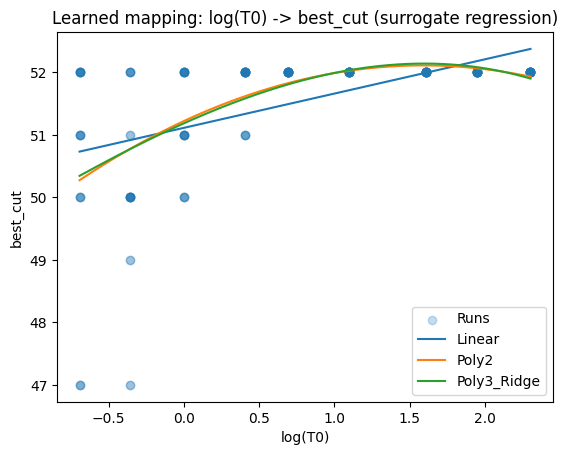

In [ ]:
# 6. Visualización de las curvas aprendidas
x_grid = np.linspace(df_reg["logT0"].min(), df_reg["logT0"].max(), 300).reshape(-1, 1)

plt.figure()
plt.scatter(df_reg["logT0"], df_reg["best_cut"], alpha=0.25, label="Runs")

for name, model in models.items():
    model.fit(X, y_best)
    plt.plot(x_grid, model.predict(x_grid), label=name)

plt.xlabel("log(T0)")
plt.ylabel("best_cut")
plt.title("Learned mapping: log(T0) -> best_cut (surrogate regression)")
plt.legend()
plt.show()
